## Partition problem

My fitness computes total distance of each bucket to its final weight. Since genetic algorithm usually maximizes fitness, the fitness function returns the negative of this distance.

I tried to change roulette selection to softmax selection, partly because softmax can work with negative fitness values. Softmax sharpness parameter linearly scales its input. It turned out to be quite difficult to tune the sharpness parameter, because different values are needed at different times of the run, so I tried dynamic sharpness, that increased progressively. That had some positive effect, but softmax was probably wrong selector from the get-go.

Then I tried tournament selection, which worked much better.
I then combined exponentially decreasing schedule for mutation rate, lower crossover rate to avoid premature convergence and sufficiently large population and enough generations.

When population collapses and doesn't have any diversity, crossover is useless, because it's crossing over identical individuals. To be able to track diversity throughout the run, I had to come up with some measure of diversity. I calculate the average entropy of every gene across the population, which gives me some idea about the population distribution.

In the end, crossover had negative impact. The best results were achieved with **cx_prob=0**, mutation rate exponentially decreasing from **0.005** to aproximately **0.0005** and **max_gen=30000**

In [1]:
from partition import *
from collections import namedtuple
import numpy as np
import functools
!mkdir -p partition_logs

In [2]:
def softmax(x, sharpness=1):
    x = x * sharpness
    return np.exp(x)/sum(np.exp(x))

def softmax_selector(pop, fits, k, current_gen, sharpness=1):
    # sharpness = (current_gen**0.5) * 0.000001
    # if current_gen % 50 == 0:
    #    print(f"Gen: {current_gen}, sharpness: {sharpness}")

    # constant sharpness
    sharpness = 0.0001

    return roulette_wheel_selection(pop, softmax(np.array(fits), sharpness), k)

def l1_fitness(ind, weights):
    bw = np.array(bin_weights(weights, ind))
    mean = sum(bw) / len(bw)
    l1_error = sum(abs(bw - mean))
    return utils.FitObjPair(fitness=-l1_error,
                            objective=max(bw) - min(bw))
def tournament_selection(pop, fits, k, current_gen, tournament_size=4):
    selected = []
    for _ in range(k):
        inds = [random.randrange(0, len(pop)) for i in range(tournament_size)]
        tournament_fits = [fits[ind] for ind in inds]
        
        selected.append(pop[inds[np.argmax(tournament_fits)]])
        
    return selected


Params = namedtuple("Params", ["max_gen", "pop_size", "mut_flip_prob", "cx_prob", "elitism", "tournament_size"])

MAX_GEN = 10000
exp_params = [
            Params(max_gen=MAX_GEN, pop_size=250, mut_flip_prob=0.005, cx_prob=0, tournament_size=8, elitism=True),

            Params(max_gen=MAX_GEN, pop_size=250, mut_flip_prob=0.005, cx_prob=0.1, tournament_size=8, elitism=True),

            Params(max_gen=MAX_GEN, pop_size=250, mut_flip_prob=0.005, cx_prob=0.3, tournament_size=8, elitism=True),

            Params(max_gen=MAX_GEN, pop_size=250, mut_flip_prob=0.005, cx_prob=0.85, tournament_size=8, elitism=True)
]

with open(OUT_DIR + "/" + EXP_NAMES_LIST, "a") as f:
    for p in exp_params:
        p_name = str(p).replace(" ", "") + ",tournament"

        # softmax selection - hard to get the right sharpness parameter
        # run_experiment(exp_id = p_name, repeats=10, max_gen=p.max_gen, pop_size=p.pop_size, fitness=l1_fitness, selection=functools.partial(softmax_selector, sharpness=p.sharpness), mut_flip_prob=p.mut_flip_prob, cx_prob=p.cx_prob, elitism=p.elitism, print_every=50)

        # tournament selection is more robust than softmax - invariant to strictly increasing transformation of fitness function
        run_experiment(exp_id = p_name, repeats=10, max_gen=p.max_gen, pop_size=p.pop_size, fitness=l1_fitness, selection=functools.partial(tournament_selection, tournament_size=p.tournament_size),  mut_flip_prob=p.mut_flip_prob, cx_prob=p.cx_prob, elitism=p.elitism, print_every=500)
        f.write(p_name + "\n")
        f.flush()
        


567
 2250000  2739.00  1089.54    15.00
Gen: 9000 diversity_avg:0.024559684254968298
 2375000  3864.00  1165.68    15.00
Gen: 9500 diversity_avg:0.026407074837029417
 2500000  2515.00  1094.65    13.00
Gen: 0 diversity_avg:1.0128444814973294
  125000  4924.00  1521.44    79.00
Gen: 500 diversity_avg:0.06077232288050524
  250000  2709.00  1603.74    70.00
Gen: 1000 diversity_avg:0.05322987098715472
  375000  2642.00  1462.98    68.00
Gen: 1500 diversity_avg:0.0508152830766878
  500000  4117.00  1591.54    62.00
Gen: 2000 diversity_avg:0.050239730472895865
  625000  4157.00  1572.04    57.00
Gen: 2500 diversity_avg:0.053588960920983864
  750000  3290.00  1552.63    53.00
Gen: 3000 diversity_avg:0.053260319897208905
  875000  3118.00  1544.56    53.00
Gen: 3500 diversity_avg:0.05343102474866284
 1000000  2879.00  1533.80    43.00
Gen: 4000 diversity_avg:0.0525666147479013
 1125000  2435.00  1448.02    45.00
Gen: 4500 diversity_avg:0.052417895873867346
 1250000  2443.00  1446.94    28.00
G

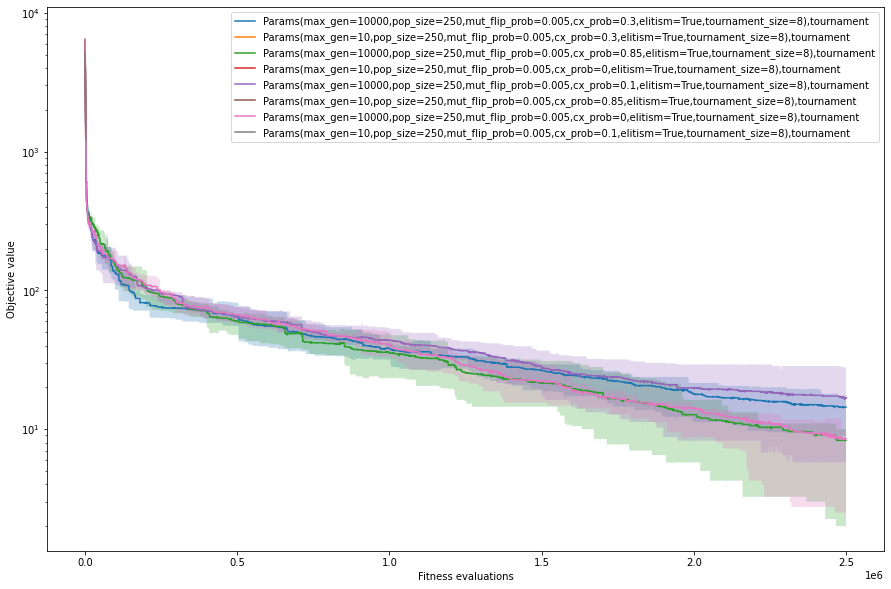

In [3]:
plot_all_experiments()

We can see, that 10000 generations is not enough for the algorithm to converge. Let's increase the **MAX_GEN** and **pop_size**

In [4]:

Params = namedtuple("Params", ["max_gen", "pop_size", "mut_flip_prob", "cx_prob", "elitism", "tournament_size"])

MAX_GEN = 30000
exp_params = [
            Params(max_gen=MAX_GEN, pop_size=1000, mut_flip_prob=0.005, cx_prob=0, tournament_size=8, elitism=True),
]

with open(OUT_DIR + "/" + EXP_NAMES_LIST, "a") as f:
    for p in exp_params:
        p_name = str(p).replace(" ", "") + ",tournament"
        run_experiment(exp_id = p_name, repeats=1, max_gen=p.max_gen, pop_size=p.pop_size, fitness=l1_fitness, selection=functools.partial(tournament_selection, tournament_size=p.tournament_size),  mut_flip_prob=p.mut_flip_prob, cx_prob=p.cx_prob, elitism=p.elitism, print_every=500)
        f.write(p_name + "\n")
        f.flush()

Gen: 0 diversity_avg:1.0129812208668045
  500000  3463.00  1505.39    64.00
Gen: 500 diversity_avg:0.09431315836058228
 1000000  4370.00  1499.07    56.00
Gen: 1000 diversity_avg:0.08598081819933456
 1500000  3755.00  1503.14    32.00
Gen: 1500 diversity_avg:0.08180161971763301
 2000000  2953.00  1532.99    23.00
Gen: 2000 diversity_avg:0.07896835520477775
 2500000  4050.00  1527.07    19.00
Gen: 2500 diversity_avg:0.08248544473598404
 3000000  3083.00  1495.63    13.00
Gen: 3000 diversity_avg:0.08323388909105676
 3500000  2309.00  1481.06    11.00
Gen: 3500 diversity_avg:0.08198326121014948
 4000000  2999.00  1472.44     6.00
Gen: 4000 diversity_avg:0.0853356678656085
 4500000  3419.00  1509.59     6.00
Gen: 4500 diversity_avg:0.08211170919545227
 5000000  3346.00  1516.83     4.00
Gen: 5000 diversity_avg:0.07830583760528649
 5500000  3260.00  1130.07     2.00
Gen: 5500 diversity_avg:0.038493088458197856
 6000000  3042.00  1110.32     0.00
Gen: 6000 diversity_avg:0.03249693805975097
 

KeyboardInterrupt: 

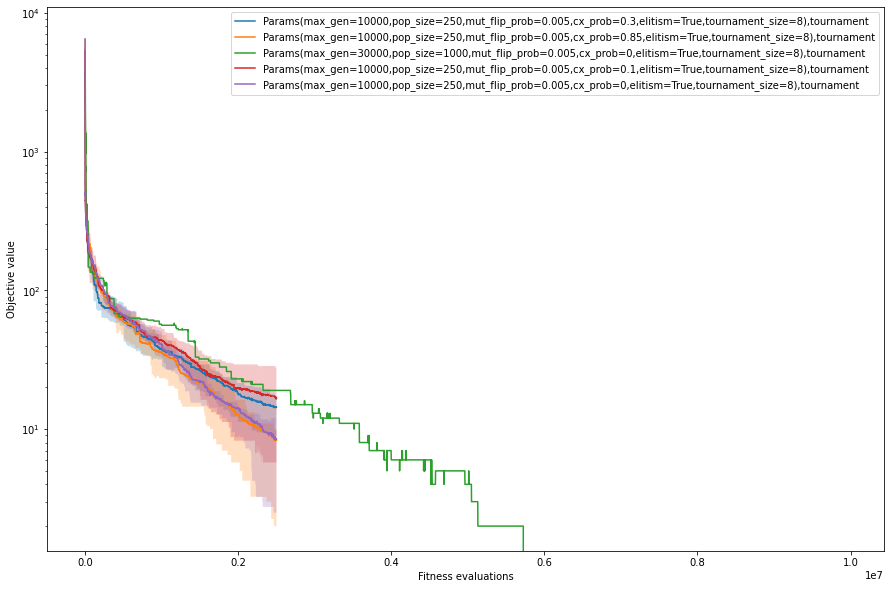

In [5]:
plot_all_experiments()

Easy version is almost too easy for it, let's try the hard input, maybe with even bigger population

In [6]:

Params = namedtuple("Params", ["max_gen", "pop_size", "mut_flip_prob", "cx_prob", "elitism", "tournament_size"])

MAX_GEN = 30000
exp_params = [
            Params(max_gen=MAX_GEN, pop_size=2000, mut_flip_prob=0.005, cx_prob=0, tournament_size=8, elitism=True),
]

with open(OUT_DIR + "/" + EXP_NAMES_LIST, "a") as f:
    for p in exp_params:
        p_name = str(p).replace(" ", "") + ",tournament"
        run_experiment(exp_id = p_name, repeats=1, max_gen=p.max_gen, pop_size=p.pop_size, fitness=l1_fitness, selection=functools.partial(tournament_selection, tournament_size=p.tournament_size),  mut_flip_prob=p.mut_flip_prob, cx_prob=p.cx_prob, elitism=p.elitism, print_every=500, input_weights='inputs/partition-hard.txt')
        f.write(p_name + "\n")
        f.flush()

Gen: 0 diversity_avg:1.0130037452694487
 1000000 28054.00 14915.35   170.00
Gen: 500 diversity_avg:0.10939168055519735
 2000000 38467.00 14727.02    59.00
Gen: 1000 diversity_avg:0.10443533458952649
 3000000 28175.00 14643.04    40.00
Gen: 1500 diversity_avg:0.09636201039924953
 4000000 34651.00 14395.78    30.00
Gen: 2000 diversity_avg:0.10085556553397353
 5000000 34347.00 14675.43    30.00
Gen: 2500 diversity_avg:0.10400989450142595
 6000000 37859.00 14786.95    29.00
Gen: 3000 diversity_avg:0.0971194690074959
 7000000 27499.00 14752.92    16.00
Gen: 3500 diversity_avg:0.09684676384785615
 8000000 22731.00 14681.91    14.00
Gen: 4000 diversity_avg:0.09900772561455999
 9000000 40247.00 14726.85    18.00
Gen: 4500 diversity_avg:0.09776217095547407
10000000 32242.00 14705.24    16.00
Gen: 5000 diversity_avg:0.10650378379997606
11000000 28036.00 10447.45     8.00
Gen: 5500 diversity_avg:0.031388671681790124
12000000 17444.00 10924.65     2.00
Gen: 6000 diversity_avg:0.030804734342336607


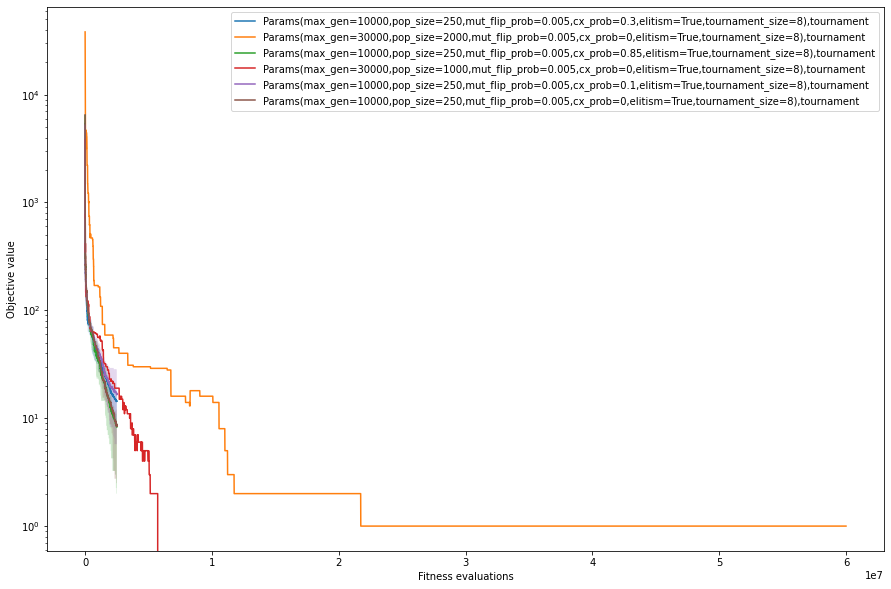

In [8]:
plot_all_experiments()

Pretty good, it almost found an optimal solution. The question is, whether objective **0** can even be achieved.